In [1]:
import pathlib
import numpy as np
from fytok.Tokamak import Tokamak
from spdm.view import View as sp_view

input_path = pathlib.Path("/home/salmon/workspace/fytok_data/data/15MA inductive - burn")

2023-11-23 12:21:16,802 [   fytok]     INFO: 
#######################################################################################################################
    ______      _____     _
   / ____/_  __|_   _|__ | | __
  / /_  / / / /  | |/ _ \| |/ /
 / __/ / /_/ /   | | (_) |   <
/_/    \__, /    |_|\___/|_|\_\
      /____/

 Copyright (c) 2021-present Zhi YU (Institute of Plasma Physics Chinese Academy of Sciences)
            
 url: https://gitee.com/openfusion/fytok_tutorial 
      https://github.com/fusion-yun/fytok_tutorial

 version = develop  (spdm=develop extension=0.2.2.dev11+g706f667, imas_version=v3_38_1_dirty)

 Run by salmon at 2023-11-23T12:21:16.802826.
 Job ID: fytok_salmon_surface_25072

#######################################################################################################################



In [2]:
tokamak = Tokamak(
    f"file+iterprofiles://{next(input_path.glob('*ASTRA.xls')).absolute().as_posix()}",
    f"file+geqdsk://{next(input_path.glob('**/g*.txt')).absolute().as_posix()}",
    device="iter",
    shot=900003,
    core_transport={"model": [{"code": {"name": "dummy"}}]},
    core_sources={
        "source": [
            {"code": {"name": "dummy"}},
            # {"code": {"name": "fusion_reaction"}},
        ]
    },
    transport_solver={
        "code": {
            "name": "fy_trans",
            "parameters": {
                "rho_tor_norm": np.linspace(0.01, 0.995, 128),
                "control_parameters": {
                    "bvp_rms_mask": [0.96],
                    "hyper_diff": 0.0001,
                    "max_nodes": 250,
                },
            },
        },
        "primary_coordinate": {"index": (index := 0), "label": r"\bar{rho}_{tor_norm}"},
        "equations": [
            # fmt: off
            {"identifier": "ion/D/density_thermal",    "boundary_condition": [2, 1]},
            {"identifier": "ion/T/density_thermal",    "boundary_condition": [2, 1]},
            {"identifier": "ion/D/temperature",        "boundary_condition": [2, 1]},
            {"identifier": "ion/T/temperature",        "boundary_condition": [2, 1]},
            {"identifier": "electrons/temperature",    "boundary_condition": [2, 1]},
            # fmt: on
        ],
    },
)

2023-11-23 12:21:16,962 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module spdm.plugins.data.plugin_xml
2023-11-23 12:21:17,182 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module spdm.plugins.data.plugin_iterprofiles
2023-11-23 12:21:17,277 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module spdm.plugins.data.plugin_geqdsk


In [3]:
tokamak.transport_solver.refresh(
    time=0.0,
    boundary_value=[[[0.0], [2.0e19]], [[0.0], [2.0e19]], [[0.0], [1000]], [[0.0], [1000]], [[0.0], [1000]]],
)

2023-11-23 12:21:17,319 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module fytok.plugins.transport_solver_numerics.fy_trans
2023-11-23 12:21:17,827 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module fytok.plugins.equilibrium.fy_eq
2023-11-23 12:21:17,913 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module spdm.mesh.mesh_rectangular
2023-11-23 12:21:18,857 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module fytok.plugins.core_transport.model.dummy
2023-11-23 12:21:18,901 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module fytok.plugins.core_sources.source.dummy
2023-11-23 12:21:18,962 [   fytok]    DEBUG: /home/salmon/workspace/fytok/python/fytok/modules/Utilities.p

/home/salmon/workspace/fytok/SpDM/python/spdm/data/Expression.py:480: RuntimeWarning: invalid value encountered in divide
  value = func(*args, **kwargs)
/home/salmon/workspace/fytok/SpDM/python/spdm/data/Expression.py:480: RuntimeWarning: divide by zero encountered in divide
  value = func(*args, **kwargs)
/home/salmon/workspace/fytok/SpDM/python/spdm/data/Expression.py:480: RuntimeWarning: invalid value encountered in multiply
  value = func(*args, **kwargs)


Singular Jacobian encountered when solving the collocation system on iteration 1. 
Maximum relative residual: 8.71e+00 
Maximum boundary residual: nan
2023-11-23 12:21:19,605 [   fytok]    DEBUG: /home/salmon/workspace/fytok/python/fytok/plugins/transport_solver_numerics/fy_trans.py:677:execute: Solve BVP failed: A singular Jacobian encountered when solving the collocation system. , 1 iterations


2023-11-23 12:21:19,631 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module spdm.view.view_matplotlib


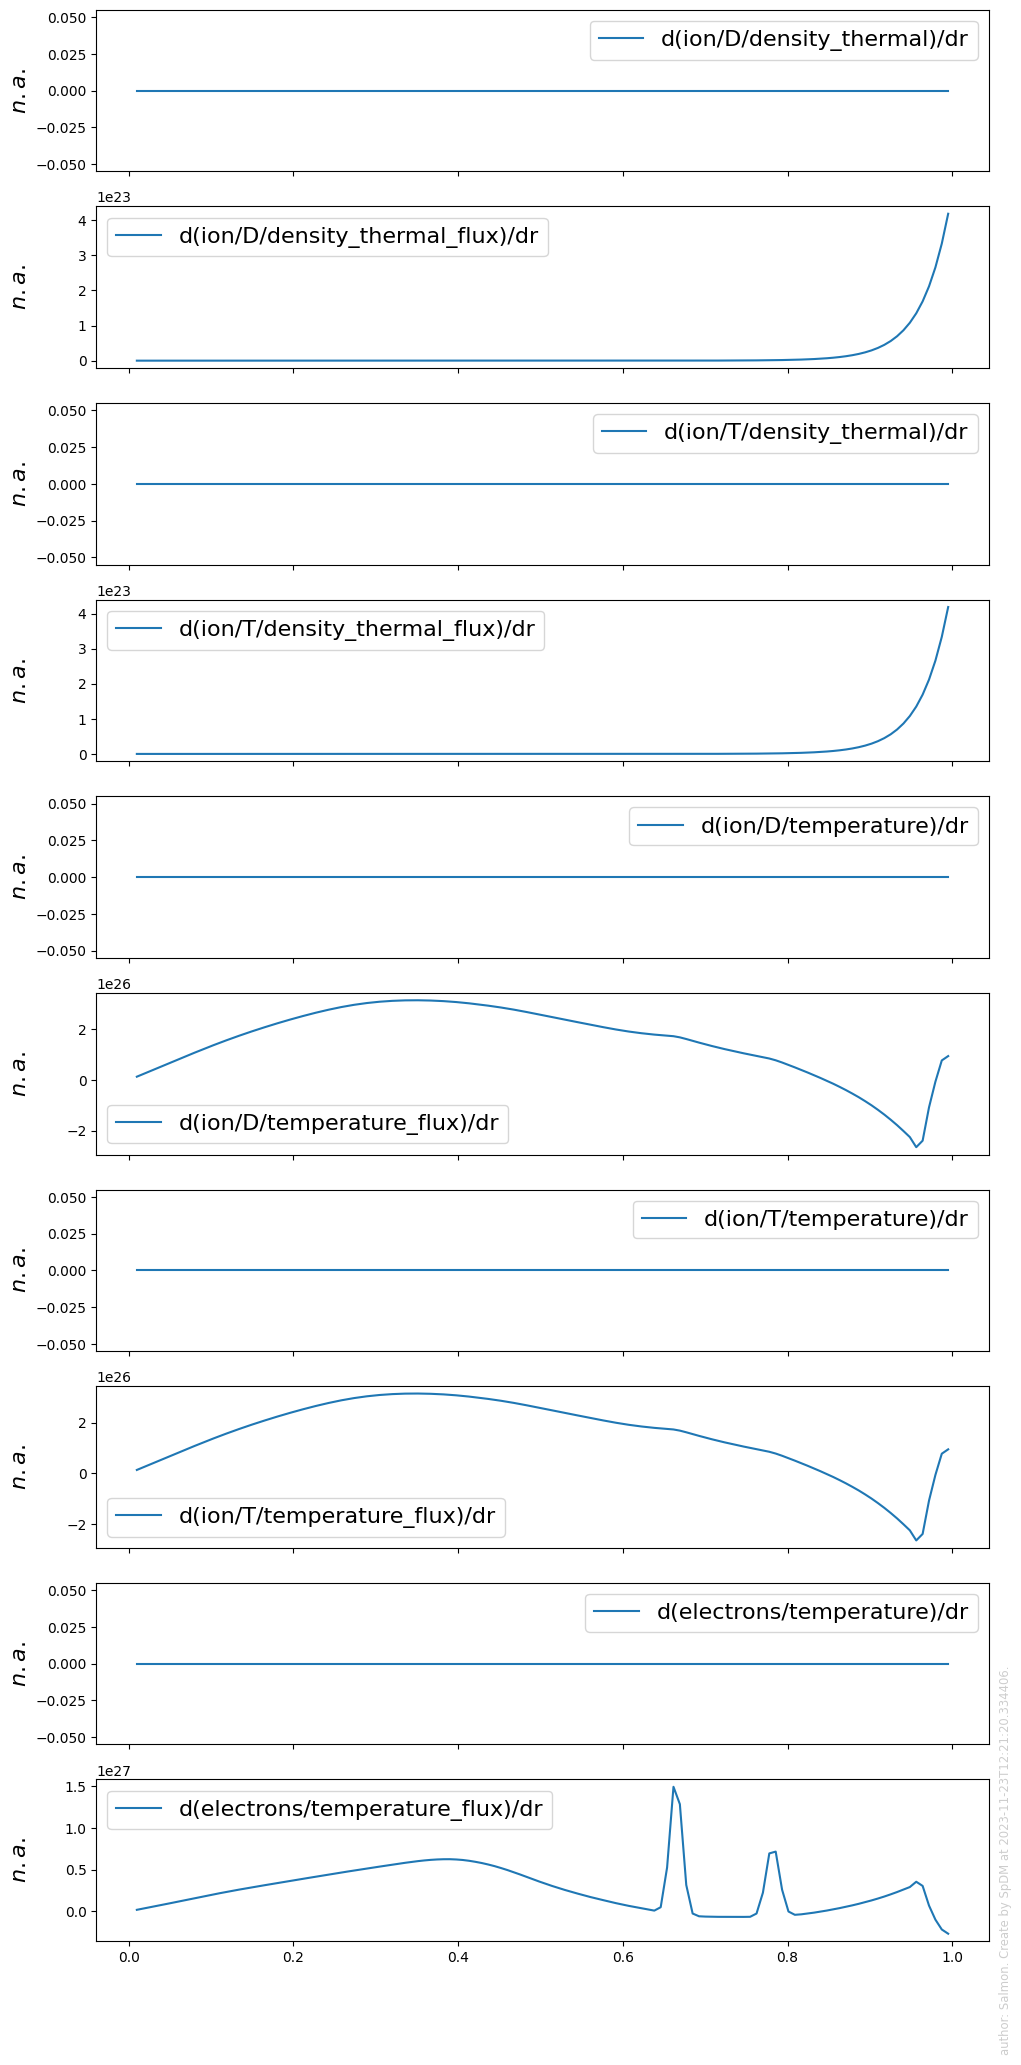

In [4]:
solver_1d = tokamak.transport_solver.time_slice.current
fig = sp_view.plot(
    sum(
        [
            [
                # (equ.primary_quantity.profile, equ.primary_quantity.identifier),
                # (equ.primary_quantity.flux, f"{equ.primary_quantity.identifier}_flux"),
                (equ.primary_quantity.d_dr,f"d({equ.primary_quantity.identifier})/dr"),
                (equ.primary_quantity.dflux_dr, f"d({equ.primary_quantity.identifier}_flux)/dr"),
            ]
            for equ in solver_1d.equation
        ],
        [],
    ),
    x_axis=solver_1d.grid.rho_tor_norm,
)

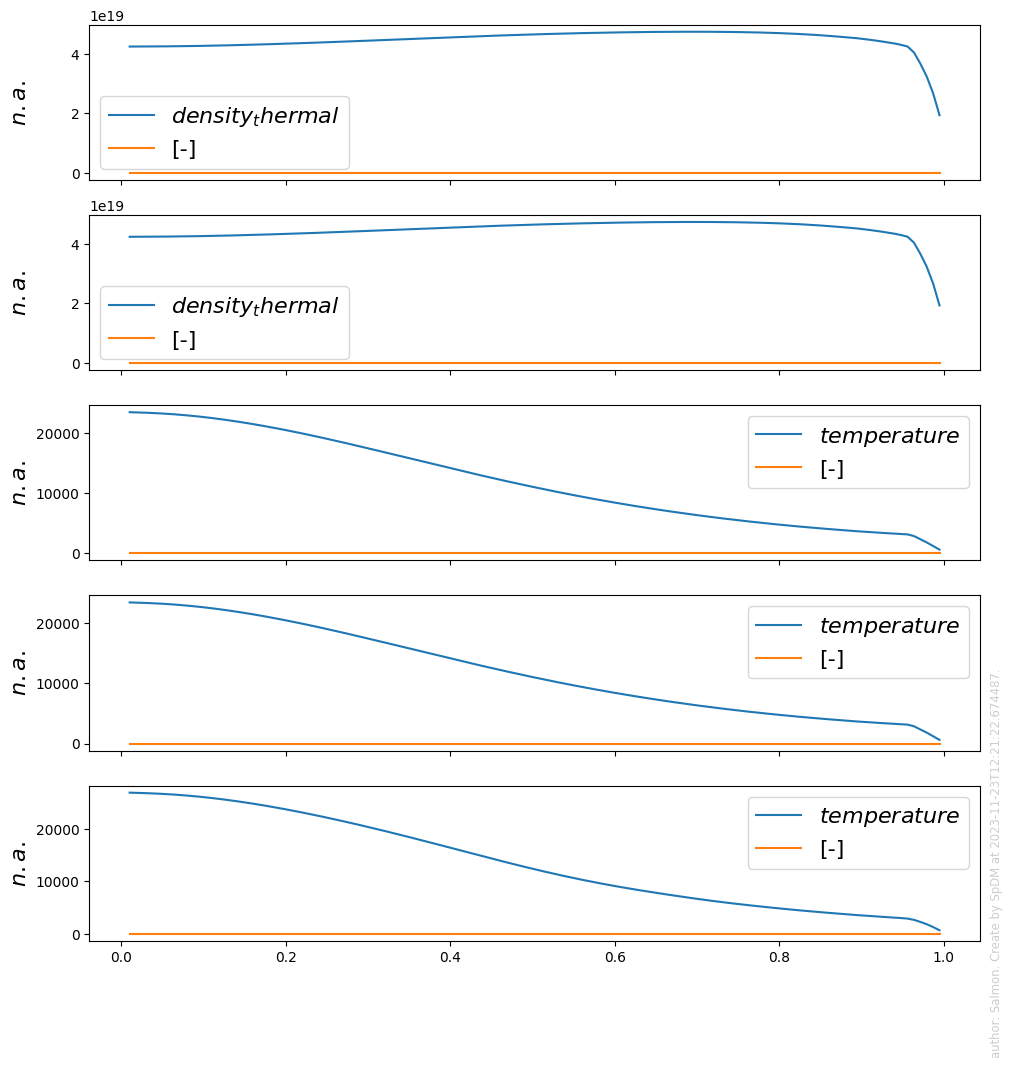

In [5]:
core_profiles_1d = tokamak.core_profiles.time_slice.current.profiles_1d
fig = sp_view.plot([
    [
        (core_profiles_1d.get(equ.primary_quantity.identifier), rf"{equ.primary_quantity.identifier} astra"),
        (equ.primary_quantity.profile, rf"{equ.primary_quantity.identifier}")
    ] for equ in solver_1d.equation
],
    x_axis=solver_1d.grid.rho_tor_norm
)

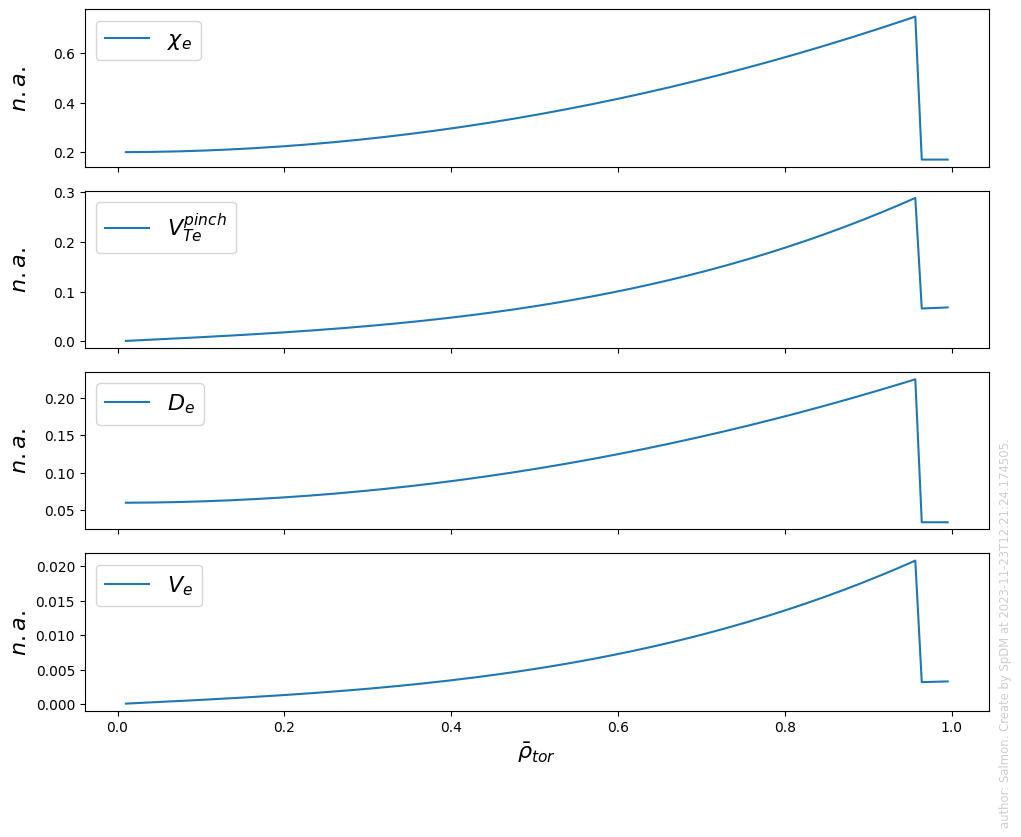

In [6]:
core_sources_1d = tokamak.core_sources.source[0].time_slice.current.profiles_1d
core_transport_1d = tokamak.core_transport.model[0].time_slice.current.profiles_1d

fig = sp_view.plot(
    [
        # (core_sources_1d.electrons.energy, r"$Q_e$"),
        (core_transport_1d.electrons.energy.d, r"$\chi_e$"),
        (core_transport_1d.electrons.energy.v, r"$V^{pinch}_{Te}$"),
        # (core_sources_1d.electrons.energy_decomposed.explicit_part, r"$Q_{e}$ explicit"),
        # (core_sources_1d.electrons.energy_decomposed.implicit_part, r"$Q_{e}$ implicit"),
        (core_transport_1d.electrons.particles.d, r"$D_e$"),
        (core_transport_1d.electrons.particles.v, r"$V_e$"),

        # (core_sources_1d.ion[0].energy, r"$Q_D$"),
        # (core_sources_1d.ion[1].energy, r"$Q_T$"),
    ],
    x_axis=solver_1d.grid.rho_tor_norm,
    x_label=r"$\bar{\rho}_{tor}$",
)

2023-11-23 12:21:24,986 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/view/view_matplotlib.py:314:plot: Plot [index=3] failed! y_label= "None"  [argument of type 'int' is not iterable] 


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2023-11-23 12:21:24,989 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/view/view_matplotlib.py:314:plot: Plot [index=4] failed! y_label= "None"  [argument of type 'int' is not iterable] 


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2023-11-23 12:21:24,992 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/view/view_matplotlib.py:314:plot: Plot [index=5] failed! y_label= "None"  [argument of type 'int' is not iterable] 


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


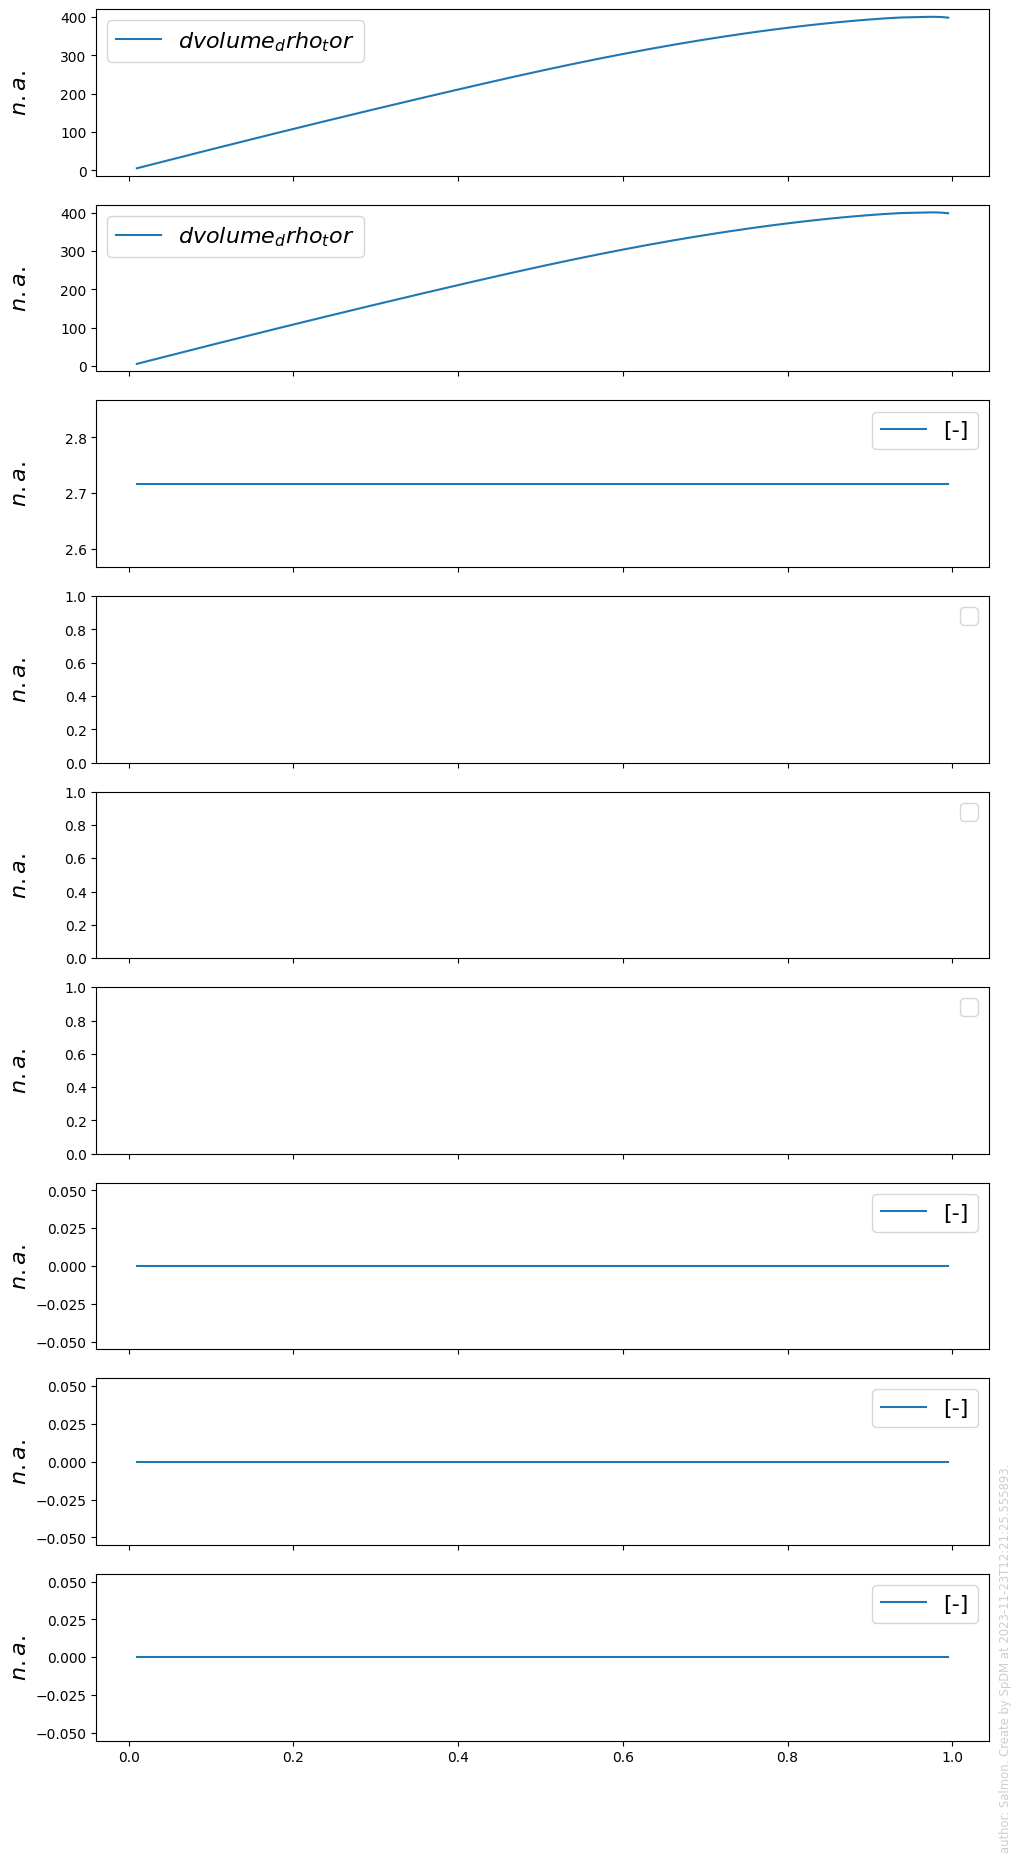

In [7]:
equ = solver_1d.equation[1]
a, b, c, d, e, f, g,*_ = equ.coefficient
x = solver_1d.grid.rho_tor_norm
y       = equ.primary_quantity.profile
yp      = equ.primary_quantity.d_dr
flux    = equ.primary_quantity.flux
dflux   = equ.primary_quantity.dflux_dr
fig = sp_view.plot([
    a, b, c, d, e, f, g,
    # [
    #     (d*yp, "$D$"),
    #     (e*y,   "$v$"),
    #     # (flux,   f"$\Gamma$"),
    #     ((c*(f - g * y)).I, r"$S$"),  # $\int c*(f - g \cdot y)$
    #     # ((-d*yp+e*y).I, r"$\Gamma$"),
    #     (-d*yp+e*y-(c*(f - g * y)).I, "residual"),

    # ],
    y, yp

    # [

    #     (dflux, {"label": r"$d\Gamma$"}),
    #     # (Function(flux, x).d(), r"$d\Gamma$"),
    #     ((c*(f - g * y)), r"$c*(f - g \cdot y)$"),
    # ],
],
    x_axis=x)